<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/pytorch_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Make classifiction data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1200

x, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
len(x), len(y)

(1200, 1200)

In [ ]:
print(x[:5])
print(y[:5])

[[ 0.77436678 -0.16684775]
 [-0.72186762  0.24689819]
 [ 0.48004702  0.86912612]
 [-0.10037767 -1.01655278]
 [ 0.81847257  0.57161308]]
[1 1 0 0 0]


In [ ]:
# make a dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": x[:, 0],
                        "X2": x[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.774367,-0.166848,1
1,-0.721868,0.246898,1
2,0.480047,0.869126,0
3,-0.100378,-1.016553,0
4,0.818473,0.571613,0


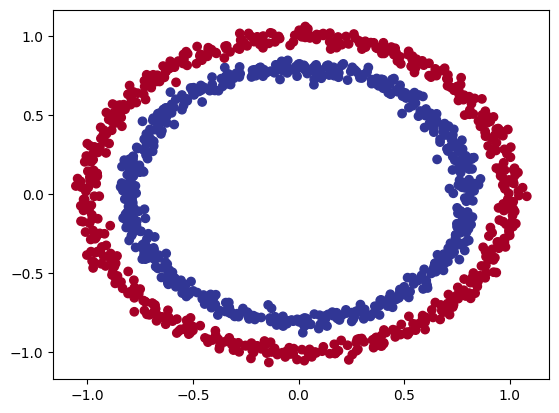

In [ ]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=x[:, 0],
            y=x[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### Turn the data into tensors and creating train and test split

In [ ]:
import torch
torch.__version__

'2.3.1+cu121'

In [ ]:
# TUrn data into tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5], y[:5]

(tensor([[ 0.7744, -0.1668],
         [-0.7219,  0.2469],
         [ 0.4800,  0.8691],
         [-0.1004, -1.0166],
         [ 0.8185,  0.5716]]),
 tensor([1., 1., 0., 0., 0.]))

In [ ]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
# split the data into training and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(x_train), len(x_test), len(y_train), len(y_test)

(960, 240, 960, 240)

In [ ]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now tha we've setup device agnostic code, let's build a model that:

1. Subclass `nn.Model`
2. create 2 `nn.Linewar()` layers capable of handling the shape of our data
3. Define a `forword()` method where we pass in the input data
4. Instantiate an instance of our model and send it to the target device


In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))   # x -> layer1 -> layer2 -> output

model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
# Create the same model using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4550, -0.5607],
                      [ 0.1492, -0.6367],
                      [ 0.5174, -0.2197],
                      [-0.4175,  0.6274],
                      [-0.6777, -0.4689]])),
             ('0.bias', tensor([-0.1798,  0.1962,  0.3810, -0.4164, -0.6495])),
             ('1.weight',
              tensor([[ 0.4266, -0.1142, -0.0700, -0.1429, -0.2883]])),
             ('1.bias', tensor([-0.4392]))])

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(x_test.to(device))

torch.round(untrained_preds[:10])


tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [ ]:
y_test[:10], x_test[:10]

(tensor([1., 1., 0., 0., 1., 1., 0., 1., 0., 1.]),
 tensor([[-0.0069,  0.7460],
         [-0.7757,  0.1825],
         [ 0.1167,  1.0160],
         [ 0.5376,  0.8535],
         [-0.4349, -0.6819],
         [ 0.1028, -0.8261],
         [ 1.0161, -0.0489],
         [ 0.8004, -0.1146],
         [ 0.4142, -0.8770],
         [ 0.7863, -0.1278]]))

## setup loss function and optimizer

Wich loss function or optimizer should you use?

Again.. This is problem specific
For Regression problem you may want to user MAE or MSE

For classification problem you may want to use cross entropy or categorical cross entropy

THe loss fucntion measures how wrong your model is

For a the logits in in deep leatning and is different form other fields of machine learning and statistial classification  

In [ ]:
# Setup loss function
# loss_fn = nn.BCELoss #  requires inputs to have gone through the sigmoid activation.

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr=0.01)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### Training a model

To train the model we need to use pytorch taining loop:

1. Forword pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backword (backpropagation)
5. Optimizer step (gradient descent)

### Going from logits -> prediction provabilities -> prediction labels
The model outputs are going to be raw **logits**.

The Logits can be converted into prediction probabilities by passing then to some kind of activation function.

In [ ]:
# view the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(x_test.to(device))[:5]
y_logits

tensor([[0.5279],
        [0.3988],
        [0.5836],
        [0.5626],
        [0.2390]])

In [ ]:
# Use the sigmoid activation function on the model classification
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6290],
        [0.5984],
        [0.6419],
        [0.6371],
        [0.5595]])

In [ ]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])
